### Подготовка

скачать репоз градкам + скачать сам датасет

In [3]:
# !pip install faiss-gpu

In [4]:
# !pip install pytorch-lightning

#### Train cars

In [5]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz

--2023-04-07 14:57:16--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  19.7MB/s    in 55s     

2023-04-07 14:58:11 (17.1 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [6]:
cd /kaggle/working/

/kaggle/working


In [7]:
!gunzip cars_train.tgz

In [8]:
!tar -xf cars_train.tar

#### Test cars

In [9]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz

--2023-04-07 14:59:28--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  19.9MB/s    in 50s     

2023-04-07 15:00:18 (18.7 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [10]:
!gunzip cars_test.tgz

In [11]:
!tar -xf cars_test.tar

#### Devkit

In [12]:
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

--2023-04-07 15:01:54--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   297KB/s    in 1.1s    

2023-04-07 15:01:56 (297 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [13]:
!gunzip car_devkit.tgz

In [14]:
!tar -xvf car_devkit.tar

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


#### GradCAM repos

In [12]:
#!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...

remote: Enumerating objects: 1097, done.

remote: Total 1097 (delta 0), reused 0 (delta 0), pack-reused 1097

Receiving objects: 100% (1097/1097), 110.14 MiB | 28.56 MiB/s, done.

Resolving deltas: 100% (610/610), done.


### Смотрим на данные  

In [15]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch.nn as nn
device = 'cuda'

In [16]:
np.random.seed(42)

In [17]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [18]:
ADD_PATH = './cars_train'

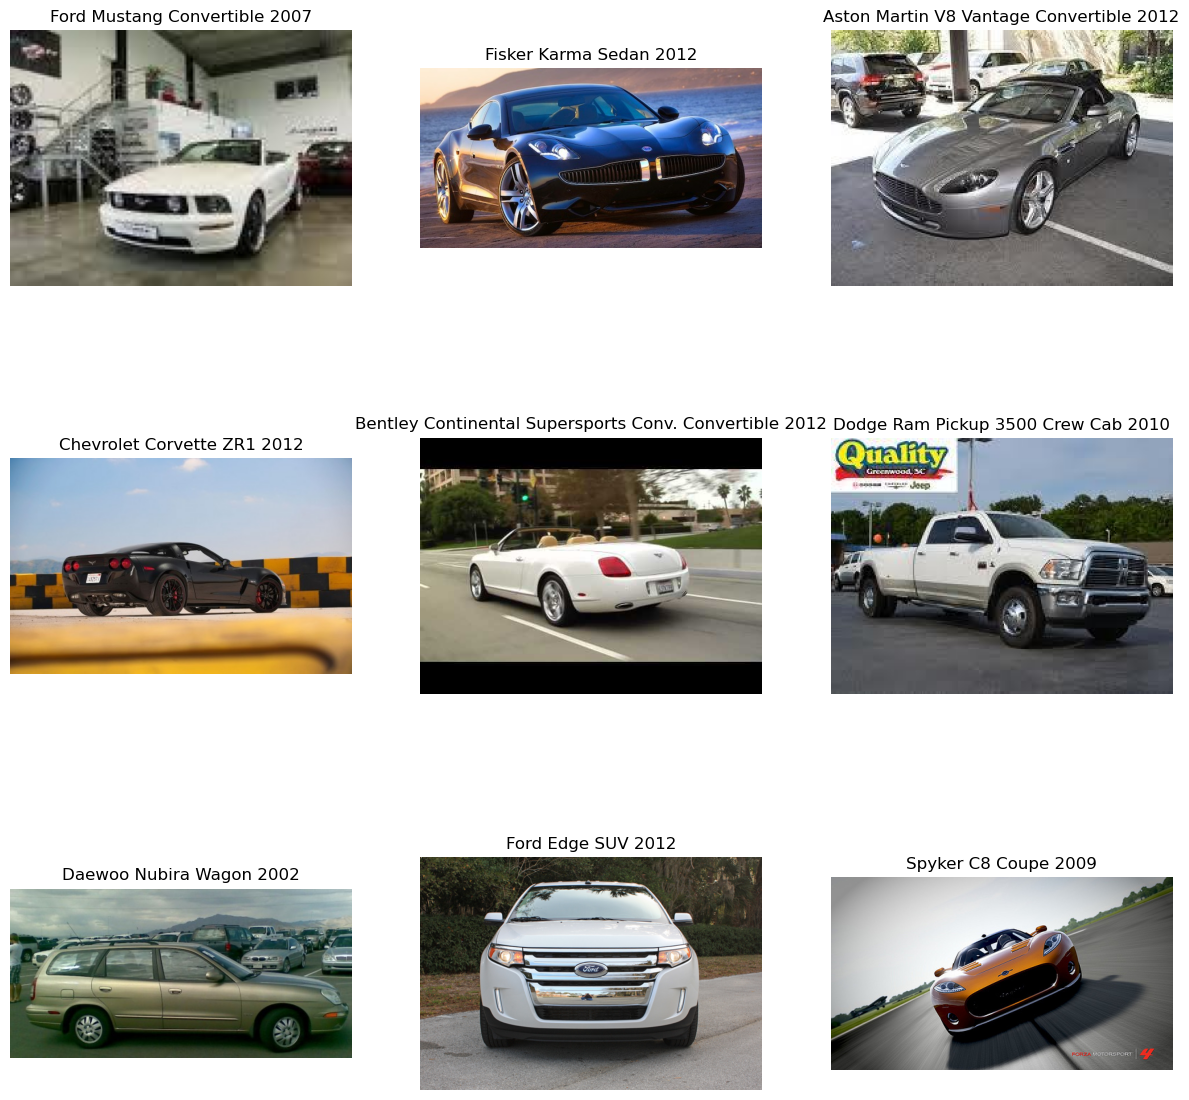

In [19]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

### Датасет + Аугментации

In [20]:
import torch
import torchvision
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_transforms =  tf.Compose([
            tf.ToPILImage(), 
            tf.Resize(size=(224, 224)),
            tf.ToTensor(),  
            tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # augmentations
            tf.RandomGrayscale(), # чтобы меньше на цвет ориентировалась 
            tf.RandomRotation((-10, 10))
            ])

val_transforms =  tf.Compose([
            tf.ToPILImage(), 
            tf.Resize(size=(224, 224)),
            tf.ToTensor(),  
            tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms=None,  train=True):
        super(TripletDataset, self).__init__()
        self.is_train = train
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        anchor_filename, anchor_label = self.cars[idx]
        anchor_img = cv2.imread(os.path.join(ADD_PATH, anchor_filename))
        anchor_img = cv2.cvtColor(anchor_img, cv2.COLOR_BGR2RGB)

        if self.is_train:
            # positive
            positive_list = [idx for idx in range(len(self.cars)) if self.cars[idx][1] == anchor_label]
            positive_idx = random.choice(positive_list)
            
            positive_filename, _ = self.cars[positive_idx]
            positive_img = cv2.imread(os.path.join(ADD_PATH, positive_filename))
            positive_img = cv2.cvtColor(positive_img, cv2.COLOR_BGR2RGB)

            # negative
            negative_list = [idx for idx in range(len(self.cars)) if self.cars[idx][1] != anchor_label]
            negative_idx = random.choice(negative_list)
            
            negative_filename, _ = self.cars[negative_idx]
            negative_img = cv2.imread(os.path.join(ADD_PATH, negative_filename))
            negative_img = cv2.cvtColor(negative_img, cv2.COLOR_BGR2RGB)

            if self.transforms:
                anchor_img = self.transforms(anchor_img)
                positive_img = self.transforms(positive_img)
                negative_img = self.transforms(negative_img)
            return anchor_img, positive_img, negative_img, anchor_label
        else:
            if self.transforms:
                anchor_img = self.transforms(anchor_img)
            return anchor_img
            

In [21]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = TripletDataset(train_items, train_transforms)
val_dataset = TripletDataset(val_items, val_transforms)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Модель

In [23]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

используем DenseNet

In [24]:
import pytorch_lightning  as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.models.densenet import densenet121, DenseNet121_Weights

class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        self.model.classifier = torch.nn.Linear(in_features=1024, out_features=emb_size, bias=True)
        
        self.classifier_head = torch.nn.Sequential(
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)))
        
        self.triplet_loss = TripletLoss()

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):

        anchor_img, pos_img, neg_img, _ = batch

        anchor_out = self.model(anchor_img)
        pos_out = self.model(pos_img)
        neg_out = self.model(neg_img)

        final_loss = self.triplet_loss(anchor_out, pos_out, neg_out)
        
        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss
    
    def validation_step(self, batch, batch_idx):
        anchor_img, pos_img, neg_img, _ = batch

        anchor_out = self.model(anchor_img)
        pos_out = self.model(pos_img)
        neg_out = self.model(neg_img)

        final_loss = self.triplet_loss(anchor_out, pos_out, neg_out)
        
        self.log("validation_loss", final_loss, sync_dist=True)
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [27]:
# model
pl_model = CarEmbedder(id_to_car, 3e-4, 512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 15, accelerator=device, devices = 1, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

In [28]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.21283136308193207    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.21283136308193207}]

In [37]:
!kill 2888

In [38]:
%reload_ext tensorboard
%tensorboard --logdir logs

In [39]:
torch.save(pl_model.state_dict(), "pl_model_weights.pth")

In [40]:
pl_model.load_state_dict(torch.load("pl_model_weights.pth"))

<All keys matched successfully>

### Метрики

In [41]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [42]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        # imgs = batch['image']
        # label = batch['label']
        imgs, _, _, label = batch
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [43]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/407 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/102 [00:00<?, ?it/s]

In [44]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(512)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index
print(index.ntotal)

# k = 4                          # we want to see 4 nearest neighbors
# D, I = index.search(train_emb[:5], k) # sanity check
# print(I)
# print(D)
# D, I = index.search(val_emb, k)     # actual search
# print(I[:5])                   # neighbors of the 5 first queries
# print(I[-5:]) 

True
6512


In [45]:
Distances, Indexes = index.search(val_emb, 1)

#### Precision@k

In [46]:
def precision_at_k(predictions, actual, k):
    sorted_preds = np.argsort(predictions)[::-1][:k]
    correct_preds = np.sum(actual[sorted_preds])
    precision = correct_preds / k
    return precision

In [51]:
precision_at_k(val_labels == train_labels[Indexes.flatten()], np.ones_like(val_labels), 1000)

1.0

#### Recall@k

In [52]:
def recall_at_k(predictions, actual, k):
    sorted_preds = np.argsort(predictions)[::-1][:k]
    correct_preds = np.sum(actual[sorted_preds])
    total_positives = np.sum(actual)
    recall = correct_preds / total_positives
    return recall

In [53]:
recall_at_k(val_labels == train_labels[Indexes.flatten()], np.ones_like(val_labels), 1000)

0.6138735420503376

#### maP

In [71]:
def average_precision(predictions, actual):
    sorted_indices = np.argsort(predictions)[::-1]
    num_positives = np.sum(actual)
    cumulative_precision = 0
    num_true_positives = 0
    for i in range(len(sorted_indices)):
        if actual[sorted_indices[i]] == 1:
            num_true_positives += 1
            precision = num_true_positives / (i + 1)
            cumulative_precision += precision
    average_precision = cumulative_precision / num_positives
    return average_precision

def maP(predictions, actual):
    average_precisions = [average_precision(pred, act) for pred, act in zip(predictions, actual)]
    maP = np.mean(average_precisions)
    return maP

In [73]:
maP([(val_labels == train_labels[Indexes.flatten()])], [np.ones_like(val_labels)])

1.0

### Смотрим на работу модели с помощью GradCAM

In [74]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=aae07eba0005dd6e79c2346812fafca7ce67cfd1d8e7714580553d2f3b297dba
  Stored in directory: /root/.cache/pip/wheels/30/aa/c4/88d65c539f7e1dc61296ec47f9870081146be6bcab6698e6a5
Successfully built grad-cam


In [75]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

In [76]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def show_grad_cam(model, num_imgs):
    model.eval()
    cols = 3
    rows = num_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
        filename, cl_id = list(fname_to_class.items())[im_idx]
        temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
        transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
        target_layers = [model.layer4]
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cam = cam(input_tensor=transformed_im)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
        pred = id_to_car[model(transformed_im).argmax().item()]
        ax[idx//cols][idx%cols].imshow(visualization)
        ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
        ax[idx//cols][idx%cols].axis('off')


def show_diff_grad_methods(model, methods):
    model.eval()
    num_imgs = 4
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.layer4]
            cam = method(model=model, target_layers=target_layers, use_cuda=True)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')

In [77]:
from PIL import Image
import requests
def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(requests.get(url, stream=True).raw))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

In [78]:
car_img, car_img_float, car_tensor = get_image_from_url("https://1.bp.blogspot.com/-wxBCzsQLWN4/ThPsv_RkoGI/AAAAAAAAAKo/wWYCiXOYsKM/s1600/2011-Dodge-Challenger-SRT8-392-feature.jpg")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_url("https://th.bing.com/th/id/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo?pid=ImgDet&rs=1")
car_concept_features = pl_model(car_tensor)[0, :]
cloud_concept_features = pl_model(cloud_tensor)[0, :]

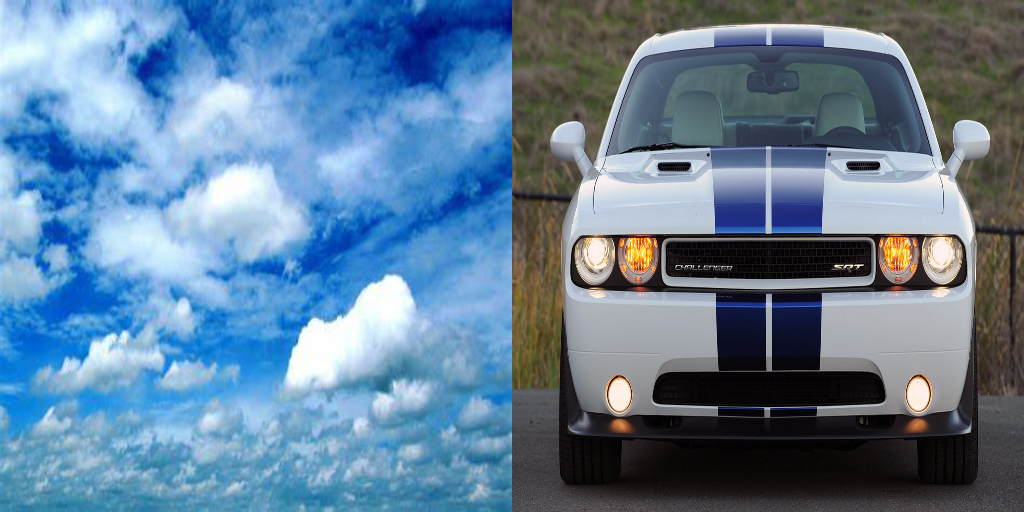

In [79]:
Image.fromarray(np.hstack((cloud_img, car_img)))

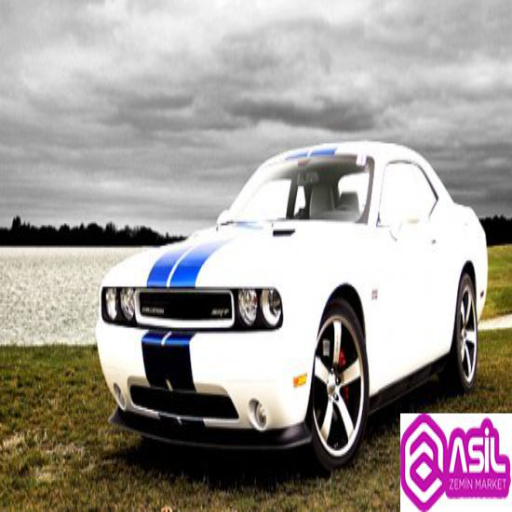

In [80]:
image, image_float, input_tensor = get_image_from_url("http://www.asilzeminmarket.com/uploaded/urunler/12/buyuk/481_1403104977_A_50jpg.jpg")
Image.fromarray(image)

In [81]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
target_layers = [pl_model.model.features.denseblock4.denselayer16]
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]


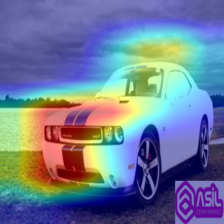

In [82]:
# Where is the car in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

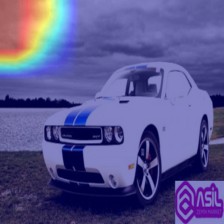

In [83]:
# Where is the cloud in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

In [84]:
class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

not_car_targets = [DifferenceFromConceptTarget(car_concept_features)]
not_cloud_targets = [DifferenceFromConceptTarget(cloud_concept_features)]

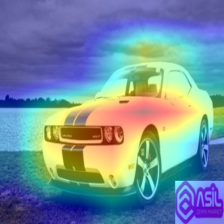

In [85]:
# Where is the cloud not in the image?
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_cloud_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

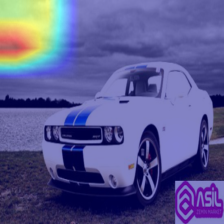

In [86]:
# Where is the car not in the image?
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_car_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_car_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

### Выводы

В целом неплохая вышла модель, однако плохо облака определяет, область могла бы быть и побольше. А вот с машинкой кайфово получилось 